In [1]:
%matplotlib inline

import os
import itertools
import glob

import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix

from ana_classification.segmentation import SegmentationResult
from ana_classification.presentation import display_grid, ImagePlotter

from numpy.random import seed
import json
from itertools import chain
seed(123)

## dataset files count for each type

In [61]:
data_dir = '../data/segmented_v2/'

def get_type_by_filename(filename):
    return filename.split('/')[-1].split('-')[0].split(']')[-1]

files = [f for f in glob.glob(data_dir + '/*.npz') if 'bad' not in f]
files_dict = {}

for f in files:
    type_ = get_type_by_filename(f)
    files_list = files_dict.get(type_, [])
    files_dict[type_] = files_list + [f]
    
for k, v in files_dict.items():
    print(f'{k}: {len(v)}')

NEG: 180
ZIA: 491
ZIA+NUC: 180
ACA: 55
ZIA+CYT: 40
ZIA+HOM: 120
NUC: 16
HOM: 67
DOT: 9
FIB: 27
AMA: 5


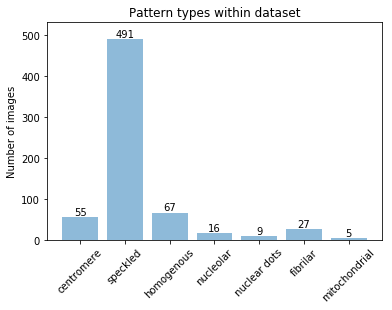

In [62]:
types = {
    'ACA': 'centromere',
    'ZIA': 'speckled',
    'HOM': 'homogenous',
    'NUC': 'nucleolar',
    'DOT': 'nuclear dots',
    'FIB': 'fibrilar',
    'AMA': 'mitochondrial'
}

y_pos = np.arange(len(types))
count = [len(files_dict[key]) for key in types.keys()]

plt.bar(y_pos, count, align='center', alpha=0.5)
plt.xticks(y_pos, types.values(), rotation=45)
plt.ylabel('Number of images')
plt.title('Pattern types within dataset')
plt.ylim((0, max(count) + 40))

for i in range(len(count)):
    plt.text(x=y_pos[i]-(0.072 * len(str(count[i]))), y=count[i]+5, s=count[i], size=10)


## loading segmented cells data

In [63]:
selected_classes = ['HOM', 'ACA', 'NUC']

selected_files = [files_dict[k] for k in selected_classes]
for k, v in zip(selected_classes, selected_files):
    print(f'{k}: {len(v)}')

HOM: 67
ACA: 55
NUC: 16


In [64]:
def load_files(files):
    return [list(SegmentationResult.load(f).cells) for f in files]

In [65]:
%%time
loaded_files = [load_files(files) for files in selected_files]
for class_, files in zip(selected_classes, loaded_files):
    count = sum([len(cells) for cells in files])
    print(f'{class_}: {count} cells')

HOM: 3102 cells
ACA: 2486 cells
NUC: 674 cells
CPU times: user 3.11 s, sys: 97.2 ms, total: 3.21 s
Wall time: 3.66 s


In [69]:
# train / validation / test split for each class
validation_files_count = [2, 3, 3]
test_files_count = [2, 2, 3]

train_cells = []
validation_cells = []
test_cells = []

for val_count, test_count, class_cells in zip(validation_files_count, test_files_count, loaded_files):
    val_c = class_cells[:val_count]
    test_c = class_cells[-test_count:]
    train_c = class_cells[val_count:-test_count]
    
    train_cells.append(list(chain(*train_c)))
    validation_cells.append(list(chain(*val_c)))
    test_cells.append(list(chain(*test_c)))
    
for class_, train, val, test in zip(selected_classes, train_cells, validation_cells, test_cells):
    print(f'{class_}: train - {len(train)}, validation - {len(val)}, test - {len(test)}')

HOM: train - 2881, validation - 95, test - 126
ACA: train - 2269, validation - 120, test - 97
NUC: train - 436, validation - 109, test - 129


In [90]:
test_files = []
for f_count, files in zip(test_files_count, selected_files):
    test_files.append(files[-f_count:])

In [91]:
test_files

[['../data/segmented_v2/HOM-011.npz', '../data/segmented_v2/HOM-024.npz'],
 ['../data/segmented_v2/ACA-015.npz', '../data/segmented_v2/ACA-044.npz'],
 ['../data/segmented_v2/NUC-005.npz',
  '../data/segmented_v2/NUC-008.npz',
  '../data/segmented_v2/NUC-011.npz']]

In [71]:
def preprocess(img, target_shape):
    
    def middle_crop(cell):
        h, w = cell.shape
        shorter = min(h, w)
        
        h_skip = (h - shorter) // 2
        v_skip = (w - shorter) // 2
        
        return cell[h_skip:h_skip+shorter, v_skip:v_skip+shorter]
    
    img = cv2.resize(middle_crop(img), target_shape)
    img = img[..., np.newaxis]
    return img / 255

def prepare_dataset(cells, target_shape):
    X = []
    y = []
    for i, cells_raw in enumerate(cells):
        cells_prep = [preprocess(c, target_shape) for c in cells_raw]
        X.append(cells_prep)
        y.append([i] * len(cells_prep))
        
    return np.concatenate(X), np.concatenate(y)

def dataset_summary(y, ax, title=''):
    labels = selected_classes
    counts = [np.sum(y == c) for c in range(len(selected_classes))]
    explode = [0.03] * len(labels)

    ax.pie(counts, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    ax.set_title(title)
    
def trim_dataset(X, y):
    counts = [np.sum(y == c) for c in range(len(selected_classes))]
    min_count = min(counts)
    X_trimmed = []
    y_trimmed = []
    
    for i in range(len(selected_classes)):
        Xi = X[y == i]
        X_trimmed.append(Xi[:min_count])
        y_trimmed.append(np.array([i] * min_count))
        
    return np.concatenate(X_trimmed), np.concatenate(y_trimmed)

In [72]:
%%time

cell_shape = (96, 96)

X_train, y_train = prepare_dataset(train_cells, cell_shape)
X_val, y_val = prepare_dataset(validation_cells, cell_shape)
X_test, y_test = prepare_dataset(test_cells, cell_shape)

CPU times: user 491 ms, sys: 182 ms, total: 672 ms
Wall time: 671 ms


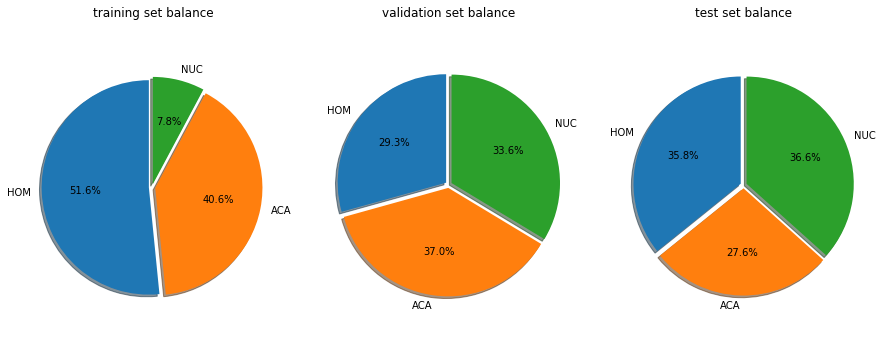

In [73]:
f, a = plt.subplots(1, 3)
f.set_size_inches((15, 6))
dataset_summary(y_train, a[0], title='training set balance')
dataset_summary(y_val, a[1], title='validation set balance')
dataset_summary(y_test, a[2], title='test set balance')

## creating data generators

In [74]:
class SingleCellDataGenerator:
    def __init__(self, X, y, batch_size, cell_lambda=None):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.order = []
        self.cell_lambda = cell_lambda

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        order = self.order
        while len(order) < self.batch_size:
            next_order_part = list(range(len(self.X)))
            np.random.shuffle(next_order_part)
            order += next_order_part
            
        order_prefix = order[:self.batch_size]
        self.order = order[self.batch_size:]
        
        selected_X = self.X[order_prefix]
        selected_y = self.y[order_prefix]
        
        if self.cell_lambda is not None:
            selected_cells = np.apply_along_axis(self.cell_lambda, axis=0, arr=selected_cells)
        
        return selected_X, selected_y
    
def cell_data_generator(X, y, batch_size, cell_lambda=None, shuffle=True):

    classes = y.max() + 1
    cells_of_type_per_batch = batch_size // classes

    generators = []
    for c in range(classes):
        class_idx = y == c
        X_class = X[class_idx]
        y_class = y[class_idx]
        generators.append(SingleCellDataGenerator(X_class, y_class, cells_of_type_per_batch, cell_lambda))

    while True:
        X = []
        y = []

        for i, g in enumerate(generators):
            X_c, y_c = next(g)
            X.append(X_c)
            y.append(y_c)

        X = np.concatenate(X)
        y = np.concatenate(y)

        if shuffle:
            indices = np.array(list(range(X.shape[0])))
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]

        yield X, y

## training model

In [78]:
classes_number = len(selected_classes)

model_input = keras.Input(shape=(cell_shape[0], cell_shape[1], 1), name='img')
x = layers.Conv2D(8, 11, activation='relu')(model_input)
x = layers.Conv2D(8, 11, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(8, 7, activation='relu')(x)
x = layers.Conv2D(8, 7, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(8, 5, activation='relu')(x)
x = layers.Conv2D(8, 5, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(10, activation='relu')(x)
model_output = layers.Dense(classes_number, activation='softmax')(x)

model = keras.Model(model_input, model_output, name='cells-classifier')
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "cells-classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 86, 86, 8)         976       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 76, 76, 8)         7752      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 38, 38, 8)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 8)         3144      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 26, 26, 8)         3144      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 8)    

In [79]:
%%time

batch_size = 128
steps_per_epoch = 10
epochs = 20

generator = cell_data_generator(X_train, y_train, batch_size=batch_size)

history = model.fit_generator(
    generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    shuffle=True,
    validation_data=(X_val, y_val)
)

Epoch 1/20
10/10 [==============================] - 17s 2s/step - loss: 1.0888 - acc: 0.4968 - val_loss: 1.0575 - val_acc: 0.5864
Epoch 2/20
10/10 [==============================] - 16s 2s/step - loss: 1.0043 - acc: 0.5167 - val_loss: 0.9166 - val_acc: 0.5926
Epoch 3/20
10/10 [==============================] - 16s 2s/step - loss: 0.9773 - acc: 0.5175 - val_loss: 0.8878 - val_acc: 0.6173
Epoch 4/20
10/10 [==============================] - 16s 2s/step - loss: 0.8578 - acc: 0.6079 - val_loss: 0.8626 - val_acc: 0.5957
Epoch 5/20
10/10 [==============================] - 16s 2s/step - loss: 0.7641 - acc: 0.6175 - val_loss: 0.7747 - val_acc: 0.6543
Epoch 6/20
10/10 [==============================] - 16s 2s/step - loss: 0.6986 - acc: 0.6714 - val_loss: 0.7077 - val_acc: 0.6852
Epoch 7/20
10/10 [==============================] - 16s 2s/step - loss: 0.6233 - acc: 0.7230 - val_loss: 0.6854 - val_acc: 0.6852
Epoch 8/20
10/10 [==============================] - 16s 2s/step - loss: 0.6078 - acc: 0.73

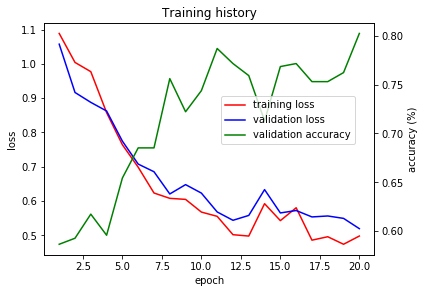

In [80]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

x = list(range(1, len(train_loss) + 1))

# plt.plot(x, train_loss, c='red', label='training loss')
# plt.plot(x, val_loss, c='blue', label='validation loss')
# plt.legend()

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.plot(x, train_loss, color='red', label='training loss')
ax1.plot(x, val_loss, color='blue', label='validation loss')
ax2 = ax1.twinx()

ax2.set_ylabel('accuracy (%)')
ax2.plot(x, val_acc, color='green', label='validation accuracy')

fig.tight_layout()
fig.legend(loc='lower left', bbox_to_anchor=(0.5, 0.5))

# plt.ylim((0, 1.3))
plt.title("Training history")
plt.show()

In [81]:
model_dir = './classifier-17.12/' # be careful not to overwrite existing model
model.save(model_dir + 'model.h5')

In [82]:
serializable_history = {}
for k, v in history.history.items():
    serializable_history[k] = [str(float_) for float_ in v]
    
serializable_history

{'loss': ['1.0888406395912171',
  '1.0042875945568084',
  '0.9773319125175476',
  '0.8578207194805145',
  '0.7641066074371338',
  '0.6985664308071137',
  '0.623336923122406',
  '0.6077680617570878',
  '0.6047231793403626',
  '0.5677163660526275',
  '0.5552814602851868',
  '0.501701807975769',
  '0.4977276086807251',
  '0.5922161787748337',
  '0.5427202910184861',
  '0.5802813351154328',
  '0.4857317715883255',
  '0.4957564830780029',
  '0.4738029420375824',
  '0.49781781136989595'],
 'acc': ['0.4968254',
  '0.51666665',
  '0.51746035',
  '0.6079365',
  '0.6174603',
  '0.67142856',
  '0.72301584',
  '0.7349206',
  '0.75079364',
  '0.75793654',
  '0.77063495',
  '0.78333336',
  '0.79444444',
  '0.74841267',
  '0.7626984',
  '0.7626984',
  '0.8119048',
  '0.7904762',
  '0.8063492',
  '0.78333336'],
 'val_loss': ['1.0575484832127888',
  '0.9166353146235148',
  '0.8877610564231873',
  '0.8625865578651428',
  '0.7746597528457642',
  '0.7077169815699259',
  '0.6853809952735901',
  '0.62053096

In [83]:
hist_json = json.dumps(serializable_history)
f = open(model_dir + 'training_history.json', 'w')
f.write(hist_json)
f.close()

In [84]:
test_pred = model.predict(X_test)
test_pred = np.argmax(test_pred, axis=1)
validation = (test_pred == y_test)
np.mean(validation)

0.8352272727272727

In [85]:
def predictions_matrix(y_true, y_pred, labels):
    result = {}
    for true, l in enumerate(labels):
        true_samples = y_true == true
        record = {}
        for pred in range(len(labels)):
            pred_name = f'pred {labels[pred]}'
            pred_count = np.sum(y_pred[true_samples] == pred)
            record[pred_name] = pred_count
            
        true_name = f'true {labels[true]}'
        result[true_name] = record
        
    return result

In [86]:
pred_mat = predictions_matrix(y_test, test_pred, selected_classes)
pred_mat

{'true HOM': {'pred HOM': 125, 'pred ACA': 0, 'pred NUC': 1},
 'true ACA': {'pred HOM': 0, 'pred ACA': 78, 'pred NUC': 19},
 'true NUC': {'pred HOM': 28, 'pred ACA': 10, 'pred NUC': 91}}

In [87]:
incorrect_X = X_test[validation == False]
incorrect_X = incorrect_X.reshape(incorrect_X.shape[:3])
incorrect_true_y = y_test[validation == False]
incorrect_pred_y = test_pred[validation == False]
titles = [f'true: {selected_classes[t]}, pred: {selected_classes[p]}'
          for t, p in zip(incorrect_true_y, incorrect_pred_y)]

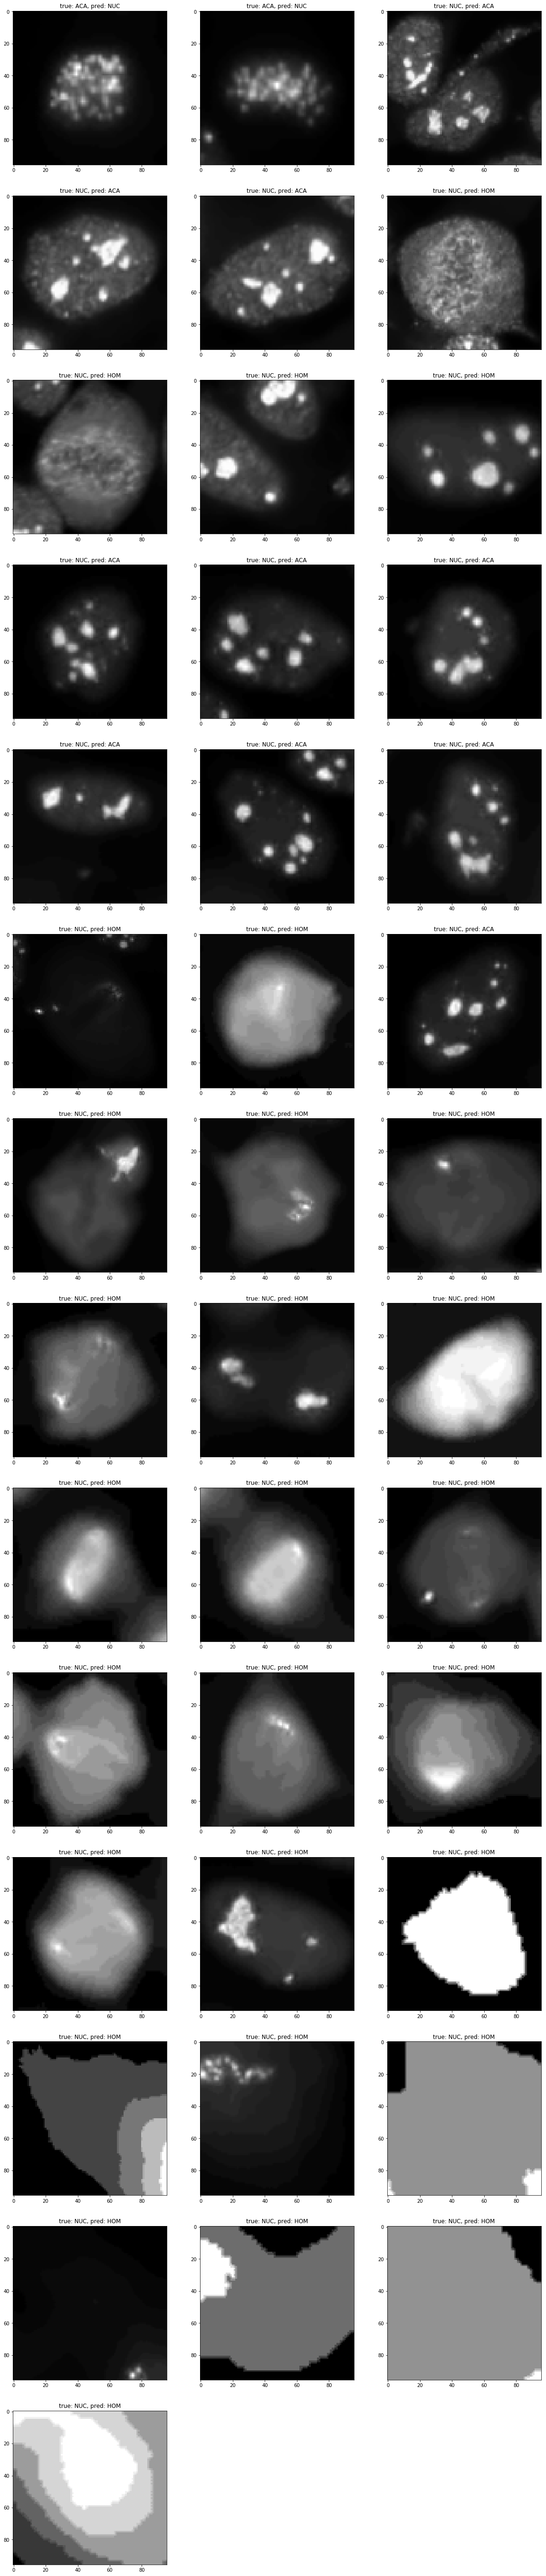

In [88]:
display_grid(incorrect_X[-40:], ImagePlotter(), titles=titles[-40:])

## loading saved model

In [89]:
reloaded = keras.models.load_model('./classifier-17.12/model.h5')
reloaded.summary()

Model: "cells-classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 86, 86, 8)         976       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 76, 76, 8)         7752      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 38, 38, 8)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 8)         3144      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 26, 26, 8)         3144      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 8)    

In [93]:
%%time

cell_shape = (96, 96)


files_to_check = [
    ['../data/segmented_v2/HOM-011.npz', '../data/segmented_v2/HOM-024.npz'],
    ['../data/segmented_v2/ACA-015.npz', '../data/segmented_v2/ACA-044.npz'],
    [
        '../data/segmented_v2/NUC-005.npz',
        '../data/segmented_v2/NUC-008.npz'
    ]
]

results = {}

for class_, class_files in zip(selected_classes, files_to_check):
    for sample_file in class_files:
        sample_cells = list(SegmentationResult.load(sample_file).cells)
        sample_cells = np.array([preprocess(c, cell_shape) for c in sample_cells])
        preds = model.predict(sample_cells)
        pred_classes = np.argmax(preds, axis=1)
        results[sample_file] = pred_classes
        print('.', end='')
        
    print(f'  {class_} done')

..  HOM done
..  ACA done
..  NUC done
CPU times: user 4.99 s, sys: 84.3 ms, total: 5.07 s
Wall time: 648 ms


In [94]:
# ['ZIA', 'HOM', 'ACA']
results

{'../data/segmented_v2/HOM-011.npz': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 '../data/segmented_v2/HOM-024.npz': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 '../data/segmented_v2/ACA-015.npz': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1]),
 '../data/segmented_v2/ACA-044.npz': array([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1,
        1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1]),
 '../data/segmented_v2/NUC-005.npz': array([2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2,

In [89]:
preds = reloaded.predict(X_test)

In [90]:
test_pred = np.argmax(preds, axis=1)
validation = (test_pred == y_test)
np.mean(validation)

0.762170790103751